In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
from PIL import Image
from sklearn import preprocessing
from random import shuffle

Reading data...
Number of raw images: 	10

Reading annotated images of segmentation...
Number of annotated images: 	10

All raw images are annotated.

An example of raw data and its annotation: 


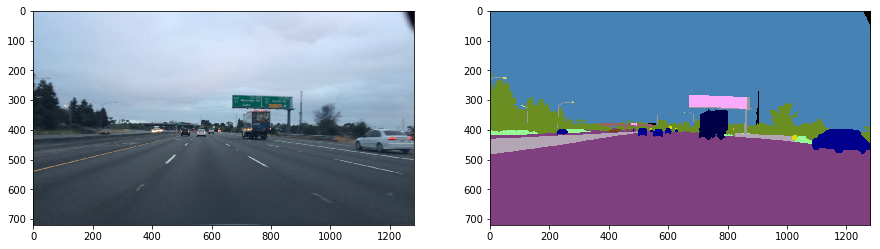

In [2]:
#Reading data
print("Reading data...")
data_filenames = []
for root, dirs, files in os.walk('data/raw_images/'):  
    for filename in files:
        data_filenames.append(filename)

data = [np.array(Image.open('data/raw_images/' + filename)) for filename, i in zip(data_filenames , range(10))]
print("Number of raw images: \t", end="")
print(len(data))

print("\nReading annotated images of segmentation...")
annot_filenames = []
for root, dirs, files in os.walk('data/class_color/'):  
    for filename in files:
        annot_filenames.append(filename)
        
annot = [np.array(Image.open('data/class_color/' + filename)) for filename, i in zip(annot_filenames , range(10))]
print("Number of annotated images: \t", end="")
print(len(annot))
if len(data)==len(annot):
    print("\nAll raw images are annotated.\n")

print("An example of raw data and its annotation: ")

image_raw = data[0]
fig, ax = plt.subplots(1,2, figsize=(15,40))
ax[0].imshow(image_raw)
image_ann = annot[0]
ax[1].imshow(image_ann)
plt.show()

In [3]:
#Splitting data into train-validation-test parts with ratios 70-20-10
print("Splitting data into training data, validation data, test data")
nb_samples=len(data_filenames)
#Splitting ratios:
valid_split = 0.2
test_split = 0.1
train_split = 0.7
print("The ratios are: ")
print("\t train:\t", train_split )
print("\t validation::\t",valid_split )
print("\t test:\t",test_split)
    
#Splitting
data_train = np.array(data[0:int(nb_samples*(1-valid_split-test_split))])
annot_train = np.array(annot[0:int(nb_samples*(1-valid_split-test_split))])
data_valid = data[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
annot_valid = annot[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
data_test  = data[int(nb_samples*(1-test_split)):]
annot_test  = annot[int(nb_samples*(1-test_split)):]

#Separation of axes
red_train = []
for img in data_train:
    image = np.array(img.ravel(), dtype='float64')
    red_train.append(image[0::3])

print(red_train)

#Standardizing


print("Number of training samples:\t", len(data_train))
print("Number of validation samples:\t", len(data_valid))
print("Number of test samples:\t", len(data_test))

Splitting data into training data, validation data, test data
The ratios are: 
	 train:	 0.7
	 validation::	 0.2
	 test:	 0.1
Number of training samples:	 10
Number of validation samples:	 0
Number of test samples:	 0


In [4]:
#Reading .csv file containing metadata of segmentation
print("Reading file containing metadata of segmentation...")
metadf = pd.read_csv('data/categories.csv', sep=',')
print("Sneak peak:")
metadf.head()

Reading file containing metadata of segmentation...
Sneak peak:


,name,id,category,catId,color
0,unlabeled,0,void,0,"0, 0, 0"
1,dynamic,1,void,0,"111, 74, 0"
2,ego vehicle,2,void,0,"0, 0, 0"
3,ground,3,void,0,"81, 0, 81"
4,static,4,void,0,"0, 0, 0"


In [5]:
#Organizing subcategories into an array, and counting subcategories
subcat = []
no_subcat = 0
for row in metadf.name:
    subcat.append(row)
no_subcat = len(subcat)

#Organizing categories into an array
cat = []
for row in metadf.category:
    cat.append(row)

#Organizing category Ids into an array
catid = []
for row in metadf.catId:
    catid.append(row)
#Counting categories
no_cat = 1
act = catid[0]
categories = [] #array containing categories without duplication
categories.append(cat[0])
for i in range(len(catid)):
    if catid[i]!=act:
        categories.append(cat[i])
        no_cat+=1
        act=catid[i]

#Organizing subcategory RGB colors into an array
col = []
for row in metadf.color:
    c = row.replace(" ", "").split(',')
    rgb = []
    for i in c:
        rgb.append(int(i))
    col.append(rgb)
    
print('Number of segmentation subcategories:', no_subcat)
print('Number of segmentation categories:', no_cat, "\n")
print("Subcategories and their representational colors [R, G, B]: \n")
for i in range(len(subcat)):
    print("%30s \t" % subcat[i], end ="")
    print(col[i])
    
print("\nSubcategories by their categories: \n")
act = cat[0]
print(cat[0] + ":")
for i in range(no_subcat):
    if cat[i] != act:
        print("\n" + cat[i] + ":")
        act=cat[i]
    print("\t\t"+subcat[i])

Number of segmentation subcategories: 41
Number of segmentation categories: 8 

Subcategories and their representational colors [R, G, B]: 

                     unlabeled 	[0, 0, 0]
                       dynamic 	[111, 74, 0]
                   ego vehicle 	[0, 0, 0]
                        ground 	[81, 0, 81]
                        static 	[0, 0, 0]
                       parking 	[250, 170, 160]
                    rail track 	[230, 150, 140]
                          road 	[128, 64, 128]
                      sidewalk 	[244, 35, 232]
                        bridge 	[150, 100, 100]
                      building 	[70, 70, 70]
                         fence 	[190, 153, 153]
                        garage 	[180, 100, 180]
                    guard rail 	[180, 165, 180]
                        tunnel 	[150, 120, 90]
                         wall  	[102, 102, 156]
                        banner 	[250, 170, 100]
                     billboard 	[220, 220, 250]
                  lane div

An example of segmentation
	Where (RGB) depicts category: 

		 (180, 165, 180)  depicts:     guard rail
		 (153, 153, 153)  depicts:     pole   polegroup
		 (152, 251, 152)  depicts:     terrain
		 (220, 220, 0)  depicts:     traffic sign
		 (250, 170, 30)  depicts:     traffic light
		 (250, 170, 250)  depicts:     traffic sign frame
		 (220, 220, 100)  depicts:     street light
		 (150, 100, 100)  depicts:     bridge
		 (128, 64, 128)  depicts:     road
		 (111, 74, 0)  depicts:     dynamic
		 (107, 142, 35)  depicts:     vegetation
		 (70, 130, 180)  depicts:     sky
		 (0, 0, 142)  depicts:     car
		 (0, 0, 70)  depicts:     truck
		 (0, 0, 0)  depicts:     unlabeled   ego vehicle   static

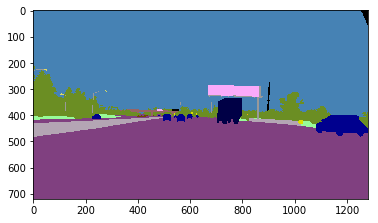

Categories and the number of pictures they occur in:
void: 10
flat: 9
construction: 9
object: 10
nature: 9
sky: 10
human: 4
vehicle: 10

Subcategories and the number of pictures they occur in: 
unlabeled: 10
dynamic: 4
ego vehicle: 10
ground: 2
static: 10
parking: 4
rail track: 0
road: 9
sidewalk: 6
bridge: 1
building: 8
fence: 0
garage: 0
guard rail: 4
tunnel: 1
wall : 4
banner: 2
billboard: 0
lane divider: 0
parking sign: 4
pole: 10
polegroup: 10
street light: 5
traffic cone: 0
traffic device: 1
traffic light: 5
traffic sign: 8
traffic sign frame: 2
terrain: 7
vegetation: 9
sky: 10
person: 4
rider: 0
bicycle: 0
bus: 1
car: 10
caravan: 0
motorcycle: 0
trailer: 0
train: 0
truck: 3


In [6]:
colors = []
for img in annot: #TODO iterating over ALL data, not only the training data
    im = Image.fromarray(img)
    im_rgb = im.convert('RGB')
    colors.append(im_rgb.getcolors()) #.getcolors() returns with a tuple: [number of occurrence, [R,G,B]]

#counting category and subcategory occurrences 
count_categories = [] #category occurrence
catcounter = [] #helper for counting categroy occurrence
count_subcategories = [] #subcategory occurrence
count_subcategories = np.zeros(len(subcat), dtype=int)
count_categories = np.zeros(no_cat, dtype=int)
catcounter = np.zeros(no_cat, dtype=int)
 
subcat_col = [] #concatenating subcategory and color arrays
for i in range(len(subcat)):
    subcat_col.append([subcat[i], col[i]])

for imcol in colors: #iterating over images
    catcounter = np.zeros(no_cat, dtype=int)
    for j in range(len(imcol)): #iterating over colors of one image   
        for i in range(len(subcat_col)): #iterating over subcategory colors
            if(tuple(subcat_col[i][1]) == imcol[j][1]): #if found
                count_subcategories[i] += 1 #increasing subcategory counter by 1
                catcounter[catid[i]] = 1 #helper for counting categories
    for c in range(len(catcounter)): #increasing ech category found in the colors of one image
        count_categories[c] += catcounter[c]
        
print("An example of segmentation")
print("\tWhere (RGB) depicts category: ")
for row in colors[0]:
    print("\n\t\t", row[1], " depicts:  ", end="")
    for i in range(len(subcat_col)): #iterating over subcategory colors
            if(tuple(subcat_col[i][1]) == row[1]): #if found
                print("  ", subcat_col[i][0], end="")
                
image = annot_train[0]
plt.imshow(image)
plt.show()


print("Categories and the number of pictures they occur in:")
for i in range(no_cat):
    print(categories[i] + ": ", end='')
    print(count_categories[i])
        
print("\nSubcategories and the number of pictures they occur in: ")
for i in range(no_subcat):
    print(subcat[i] + ": ", end='')
    print(count_subcategories[i])